In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import torch
import wandb
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from albumentations import (
    Compose, RandomRotate90, Flip, Transpose, OneOf, 
    CLAHE, RandomBrightnessContrast, RandomGamma, GaussNoise, ShiftScaleRotate,RandomResizedCrop
)
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
# Define the label mapping
LABEL_MAPPING = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

In [3]:
def preprocess_image(image_path, size=299):
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Ensure image is in uint8 format
    if image.dtype != np.uint8:
        image = (image * 255).clip(0, 255).astype(np.uint8)
    
    # Resize
    image = cv2.resize(image, (size, size))
    
    # Circular crop
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (size//2, size//2), size//2, (255, 255, 255), -1)
    image = cv2.bitwise_and(image, image, mask=mask)
    
    # CLAHE (moved to augmentation pipeline)
    # Gaussian blur for noise reduction
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Vessel enhancement
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    image = cv2.addWeighted(image, 1, cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB), 0.2, 0)
    
    return image  # Return uint8 image

def create_augmentations():
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            CLAHE(clip_limit=2, p=1),
            RandomBrightnessContrast(p=1),
            RandomGamma(p=1)
        ], p=0.3),
        GaussNoise(var_limit=(10.0, 50.0)),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        RandomResizedCrop(height=299, width=299, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), p=0.5),
    ])

In [4]:
# Custom Dataset
class DRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # Normalize to [0, 1] range
        image = image.astype(np.float32) / 255.0
        
        # Normalize using ImageNet mean and std
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean) / std
        
        # Convert to CHW format for PyTorch
        image = image.transpose(2, 0, 1)
        
        return torch.FloatTensor(image), label

    def get_label_description(self, idx):
        return LABEL_MAPPING[self.labels[idx]]


# Load and preprocess data
def load_data_paths(data_dir):
    image_paths = []
    labels = []
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        if os.path.isdir(class_path):
            label = int(class_folder)
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(label)
    return image_paths, labels

In [5]:
# Oversampling function
def oversample_minority_classes(image_paths, labels):
    classes, class_counts = np.unique(labels, return_counts=True)
    max_size = max(class_counts)
    oversampled_paths, oversampled_labels = [], []
    
    for cls in classes:
        cls_indices = np.where(np.array(labels) == cls)[0]
        cls_paths = [image_paths[i] for i in cls_indices]
        cls_labels = [labels[i] for i in cls_indices]
        
        if len(cls_paths) < max_size:
            resampled_paths, resampled_labels = resample(cls_paths, cls_labels,
                                                         n_samples=max_size,
                                                         random_state=42)
        else:
            resampled_paths, resampled_labels = cls_paths, cls_labels
        
        oversampled_paths.extend(resampled_paths)
        oversampled_labels.extend(resampled_labels)
    
    return oversampled_paths, oversampled_labels
# Calculate class weights
def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return torch.FloatTensor(class_weights)

In [6]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
# Load and preprocess data
data_dir = 'gcs/data'
image_paths, labels = load_data_paths(data_dir)


# Split the data
X_train, X_test, y_train, y_test =train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
 


In [8]:
# Oversample the training data
X_train_resampled, y_train_resampled = oversample_minority_classes(X_train, y_train)

# Calculate class weights
class_weights = calculate_class_weights(y_train_resampled)

In [9]:
# Create datasets
train_transform = create_augmentations()
train_dataset = DRDataset(X_train_resampled, y_train_resampled, transform=train_transform)
test_dataset = DRDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/var/tmp/ipykernel_39842/1249820611.py:38: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  Flip(),


In [10]:
# Print some information about the data
print(f"Original training set size: {len(X_train)}")
print(f"Resampled training set size: {len(X_train_resampled)}")
print(f"Test set size: {len(X_test)}")
print(f"Class weights: {class_weights}")

Original training set size: 3664
Resampled training set size: 4000
Test set size: 917
Class weights: tensor([1., 1., 1., 1., 1.])


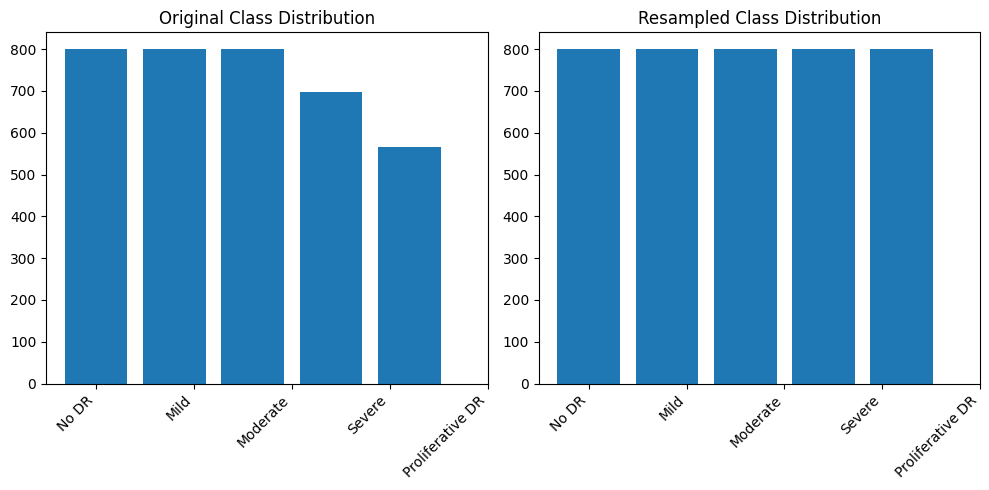

In [11]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Class Distribution")
plt.hist(y_train, bins=5, align='left', rwidth=0.8)
plt.xticks(range(5), [LABEL_MAPPING[i] for i in range(5)], rotation=45, ha='right')
plt.subplot(1, 2, 2)
plt.title("Resampled Class Distribution")
plt.hist(y_train_resampled, bins=5, align='left', rwidth=0.8)
plt.xticks(range(5), [LABEL_MAPPING[i] for i in range(5)], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.008013402].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.008214845].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.0088192485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.0088192485].


Training Images:
Image 1 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 1 shape: (299, 299, 3)
Image 2 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 2 shape: (299, 299, 3)
Image 3 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 3 shape: (299, 299, 3)
Image 4 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 4 shape: (299, 299, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.008416314].


Image 5 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 5 shape: (299, 299, 3)


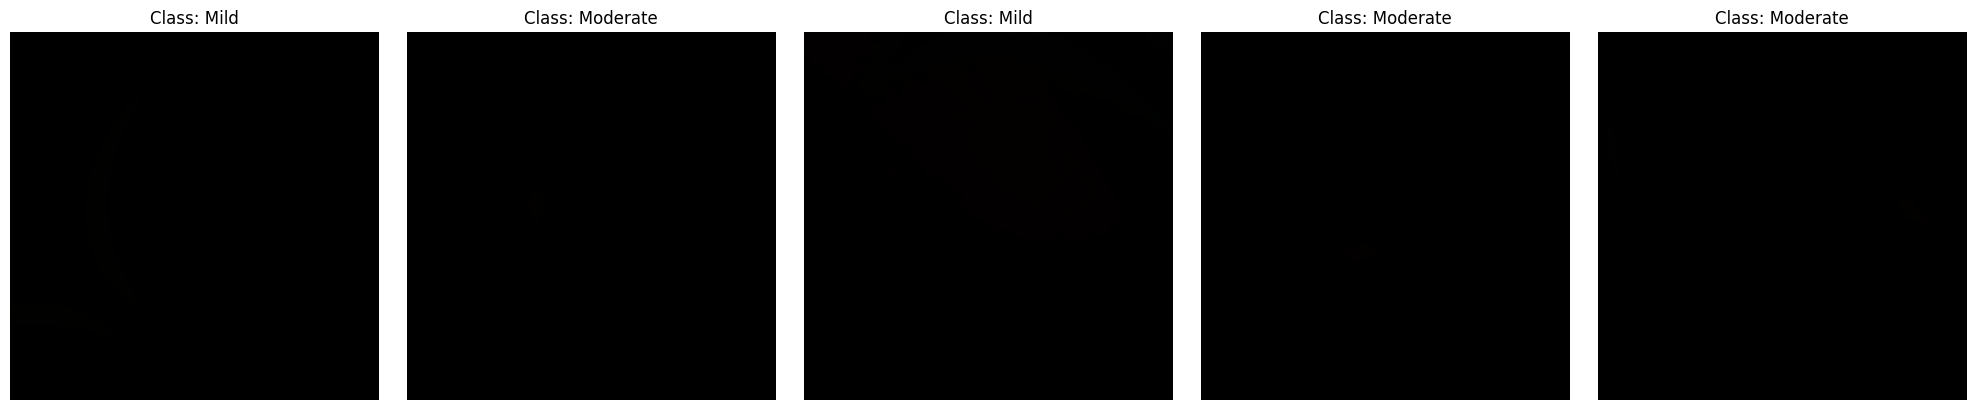

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.0088192485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.00952381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.010216242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.009043225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008305506..0.0088192485].



Test Images:
Image 1 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 1 shape: (299, 299, 3)
Image 2 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 2 shape: (299, 299, 3)
Image 3 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 3 shape: (299, 299, 3)
Image 4 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 4 shape: (299, 299, 3)
Image 5 shape: torch.Size([3, 299, 299]), dtype: torch.float32
After processing, image 5 shape: (299, 299, 3)


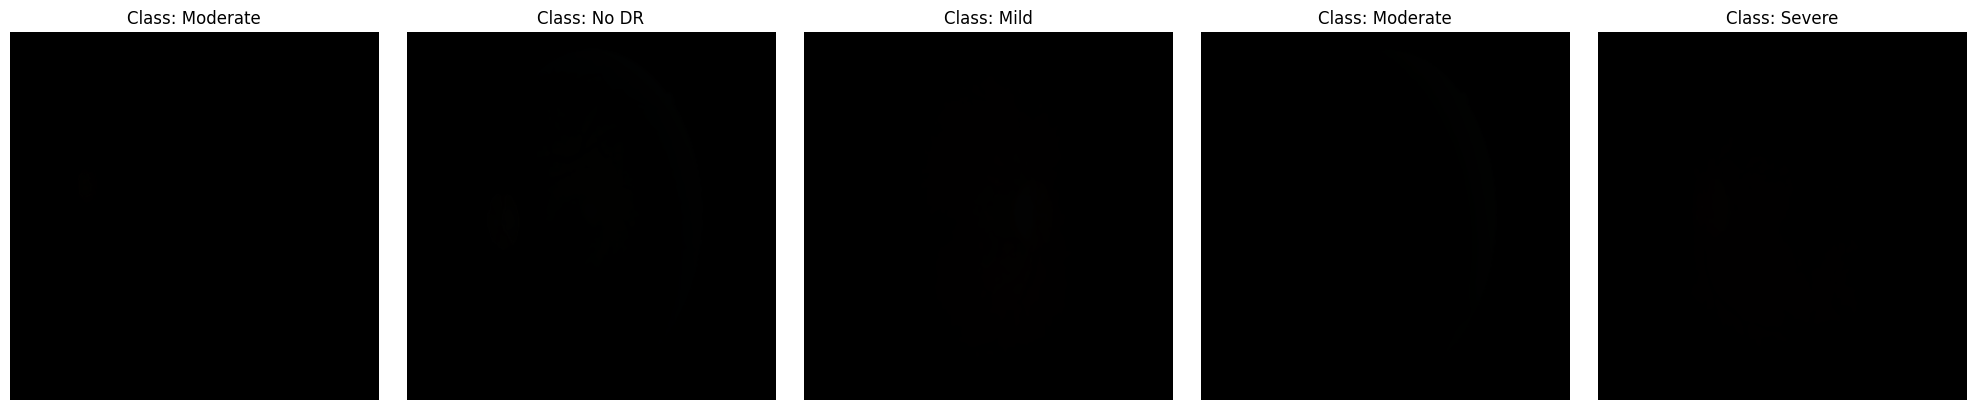

In [13]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        
        print(f"Image {i+1} shape: {img.shape}, dtype: {img.dtype}")
        
        # Convert from tensor to numpy if necessary
        if isinstance(img, torch.Tensor):
            img = img.numpy()
        
        # Handle unexpected shape
        if img.shape == (299, 299, 299):
            print(f"Unexpected shape detected for image {i+1}. Using first channel.")
            img = img[:, :, 0]
        elif len(img.shape) == 3 and img.shape[0] == 3:
            img = img.transpose(1, 2, 0)
        
        print(f"After processing, image {i+1} shape: {img.shape}")
        
        # Normalize to [0, 1] if not already
        if img.max() > 1.0:
            img = img / 255.0
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {dataset.get_label_description(idx)}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize training images
print("Training Images:")
show_images(train_dataset)

# Visualize test images
print("\nTest Images:")
show_images(test_dataset)

Augmentation Examples:


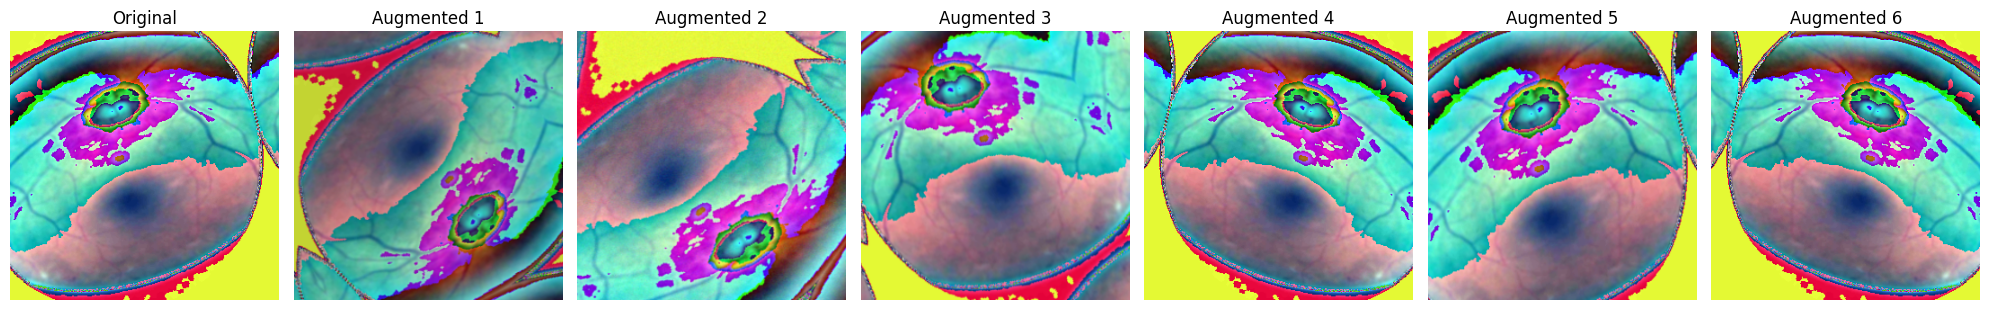

In [19]:
def show_augmentations(dataset, num_augmentations=6):
    idx = np.random.randint(len(dataset))
    original_img, label = dataset[idx]
    original_img = original_img.numpy().transpose(1, 2, 0)
    
    # Convert to uint8
    original_img = (original_img * 255).astype(np.uint8)
    
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(20, 4))
    axes[0].imshow(original_img)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    for i in range(num_augmentations):
        augmented = dataset.transform(image=original_img)['image']
        axes[i+1].imshow(augmented)
        axes[i+1].set_title(f"Augmented {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Augmentation Examples:")
show_augmentations(train_dataset)

## Model Training using Efficientnet-b3

In [20]:
def create_model(num_classes=5):
    model = EfficientNet.from_pretrained('efficientnet-b3')
    in_features = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )
    return model

model = create_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/jupyter/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 251MB/s]


Loaded pretrained weights for efficientnet-b3


In [21]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
def train_with_wandb(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    wandb.init(project="diabetic-retinopathy", name="efficientnet-b3")
    
    wandb.config.update({
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "model": model.__class__.__name__,
    })

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total

        scheduler.step(val_loss)

        wandb.log({
            "epoch": epoch,
            "train_loss": epoch_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": accuracy,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

    print('Finished Training')
    wandb.finish()

In [23]:
num_epochs = 30
train_with_wandb(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device)

wandb: Currently logged in as: shaunliew20 (shaunliew20-organization). Use `wandb login --relogin` to force relogin


/var/tmp/ipykernel_39842/1938544861.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/var/tmp/ipykernel_39842/1938544861.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/30], Train Loss: 1.4623, Train Accuracy: 35.05%, Val Loss: 3.0643, Val Accuracy: 28.24%
Epoch [2/30], Train Loss: 1.3400, Train Accuracy: 40.50%, Val Loss: 1.7257, Val Accuracy: 37.19%
Epoch [3/30], Train Loss: 1.3010, Train Accuracy: 43.23%, Val Loss: 1.2817, Val Accuracy: 40.35%
Epoch [4/30], Train Loss: 1.2681, Train Accuracy: 43.48%, Val Loss: 1.7893, Val Accuracy: 40.57%
Epoch [5/30], Train Loss: 1.2335, Train Accuracy: 45.33%, Val Loss: 1.5659, Val Accuracy: 41.55%
Epoch [6/30], Train Loss: 1.2131, Train Accuracy: 46.48%, Val Loss: 1.1699, Val Accuracy: 44.82%
Epoch [7/30], Train Loss: 1.1992, Train Accuracy: 47.38%, Val Loss: 1.4653, Val Accuracy: 45.47%
Epoch [8/30], Train Loss: 1.1837, Train Accuracy: 47.67%, Val Loss: 1.1738, Val Accuracy: 47.76%
Epoch [9/30], Train Loss: 1.1695, Train Accuracy: 47.62%, Val Loss: 1.3219, Val Accuracy: 46.13%
Epoch [10/30], Train Loss: 1.1508, Train Accuracy: 49.65%, Val Loss: 1.2190, Val Accuracy: 47.44%
Epoch [11/30], Train Loss: 1.

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,█████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▃▄▄▄▄▄▅▆▆▆▇▇▇▇▇▇█▇████████▇
train_loss,█▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇███████████████
val_loss,█▃▂▄▃▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning_rate,0.0
train_accuracy,58.825
train_loss,0.91765
val_accuracy,54.52563


In [24]:
# Save the model    
torch.save(model.state_dict(), 'diabetic_retinopathy_effectivenet_model.pth')

In [25]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=[LABEL_MAPPING[i] for i in range(5)]))
print(confusion_matrix(all_labels, all_preds))

                  precision    recall  f1-score   support

           No DR       0.49      0.59      0.54       200
            Mild       0.49      0.48      0.49       200
        Moderate       0.44      0.32      0.37       200
          Severe       0.63      0.69      0.66       175
Proliferative DR       0.71      0.70      0.71       142

        accuracy                           0.55       917
       macro avg       0.55      0.56      0.55       917
    weighted avg       0.54      0.55      0.54       917

[[119  58  18   2   3]
 [ 73  97  24   3   3]
 [ 44  38  64  41  13]
 [  4   3  26 120  22]
 [  4   0  13  25 100]]


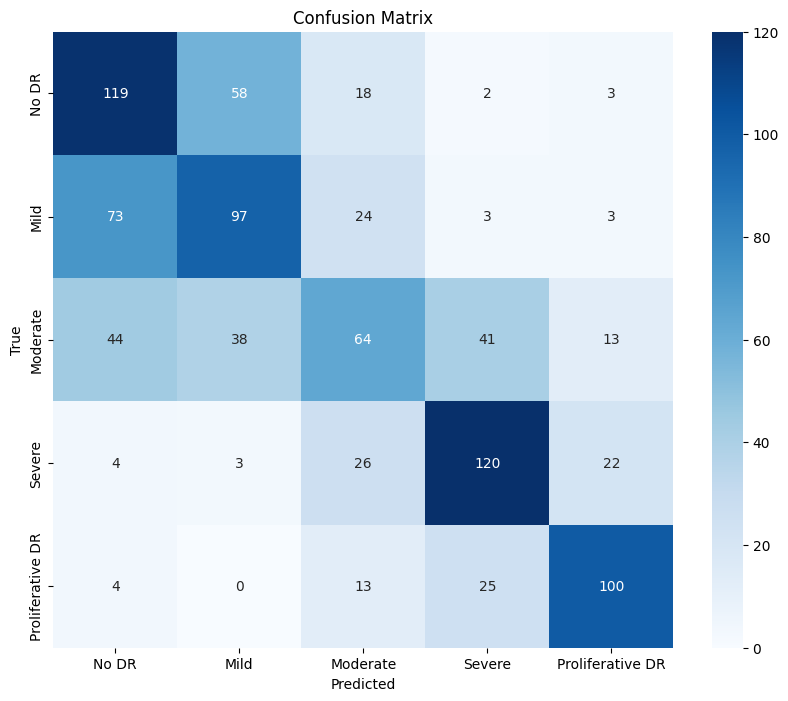

In [26]:
# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[LABEL_MAPPING[i] for i in range(5)], 
            yticklabels=[LABEL_MAPPING[i] for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
def load_trained_model(model_path, num_classes=5):
    # Create a new instance of the model
    model = EfficientNet.from_pretrained('efficientnet-b3')
    
    # Load the saved state dict
    state_dict = torch.load(model_path)
    
    # Check if the state dict has the unexpected structure
    if '_fc.1.weight' in state_dict and '_fc.1.bias' in state_dict:
        # Modify the model's fc layer to match the saved state dict
        in_features = model._fc.in_features
        model._fc = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features, num_classes)
        )
    else:
        # If the state dict has the expected structure, just modify the last layer
        in_features = model._fc.in_features
        model._fc = torch.nn.Linear(in_features, num_classes)
    
    # Load the state dict
    model.load_state_dict(state_dict)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# Load the model
model_path = 'diabetic_retinopathy_effectivenet_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_trained_model(model_path).to(device)

print("Model loaded successfully and moved to", device)

Loaded pretrained weights for efficientnet-b3
Model loaded successfully and moved to cuda


/var/tmp/ipykernel_39842/2967984922.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [29]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=[LABEL_MAPPING[i] for i in range(5)]))
print(confusion_matrix(all_labels, all_preds))

                  precision    recall  f1-score   support

           No DR       0.49      0.59      0.54       200
            Mild       0.49      0.48      0.49       200
        Moderate       0.44      0.32      0.37       200
          Severe       0.63      0.69      0.66       175
Proliferative DR       0.71      0.70      0.71       142

        accuracy                           0.55       917
       macro avg       0.55      0.56      0.55       917
    weighted avg       0.54      0.55      0.54       917

[[119  58  18   2   3]
 [ 73  97  24   3   3]
 [ 44  38  64  41  13]
 [  4   3  26 120  22]
 [  4   0  13  25 100]]


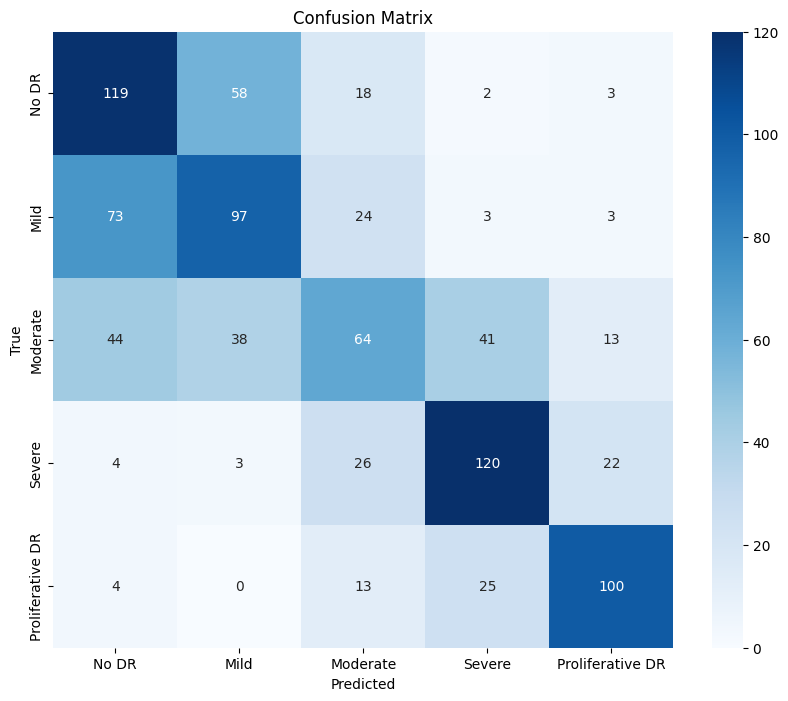

In [30]:
# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[LABEL_MAPPING[i] for i in range(5)], 
            yticklabels=[LABEL_MAPPING[i] for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()